# Compare KE budgets

In [1]:
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
from dask.diagnostics import ProgressBar
import matplotlib.pylab as pylab
import dask

In [3]:
exp_list = [
    'biharmonic Smag',
    'QG Leith'
]
run_list = [
    'nw2_0.03125deg_N15_baseline_diags',
    'nw2_0.03125deg_N15_QG_Leith_v3'
]
times_list = [
    ['00001002', '00001102', '00001202'],
    ['00001202', '00001302', '00001402']
]

In [4]:
chunks = {'time': 1}

In [5]:
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2' 

st_list = []
av_list = []
for run, times in zip(run_list, times_list):
    st = xr.open_dataset('%s/%s/static.nc' % (path, run), decode_times=False)
    st_list.append(st)
    
    file_list = []
    for time in times:
        file = '%s/%s/averages_%s.nc' % (path, run, time)
        file_list.append(file)
    av = xr.open_mfdataset(file_list, decode_times=False, chunks=chunks, combine='by_coords')
    av_list.append(av)

In [6]:
for av in av_list:
    av['hKE'] = av['h'] * av['KE']

In [7]:
nr_days = 5* len(av.time)
nr_days

300

## Compute time mean

In [8]:
dst_list = []
for av in av_list:
    dst = av.mean(dim='time')
    dst_list.append(dst)

### Load some data

In [9]:
fld_list = [
    'KE_stress', 'KE_visc', 'KE_horvisc', 'hKE'
]

with ProgressBar():
    for dst in dst_list:
        for fld in fld_list:
            dst[fld].load()

[####################################### ] | 99% Completed |  1min 14.8s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 15.0s
[####################################### ] | 99% Completed |  1min 16.2s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 16.3s
[####################################### ] | 99% Completed |  1min 19.1s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 19.2s
[####################################### ] | 99% Completed |  2min 17.6s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 17.7s
[####################################### ] | 99% Completed |  1min 14.0s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 14.3s
[####################################### ] | 99% Completed |  1min 17.3s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 17.4s
[####################################### ] | 99% Completed |  1min 13.1s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 13.2s
[####################################### ] | 99% Completed |  2min 24.2s

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 24.3s


# KE sinks

### Partition vertical stresses into bottom drag and vertical viscosity contributions

In [43]:
# the following two values are for the mask that identifies the bottom layer (cf: make_bottom_mask)
workpath = '/glade/work/eyankovsky/'
threshold_vanished = 5 # threshold for layer thickness for decomposing into upper and lower layers

ds_mask_list = []
for run in run_list:
    filename = '%s/%s/mask_bottom_%s.nc' %(
        workpath, run, str(threshold_vanished)
    )
    ds_mask = xr.open_dataset(filename, decode_times=False)
    ds_mask_list.append(ds_mask)

In [44]:
for dst, ds_mask in zip(dst_list, ds_mask_list):
    dst['KE_bottom_drag'] = (
        dst['KE_visc'] - dst['KE_stress']  # subtract wind stress contribution from vertical stresses
    ) * ds_mask['mask_bottom_and_below']  # extract the bit in the bottom layer

    dst['KE_vertical_viscosity'] = dst['KE_visc'] - dst['KE_stress'] - dst['KE_bottom_drag']

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
import copy
#cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
cmap.set_bad(color='gray')
extent = [0, 60, -70, 70]

### 2D plots

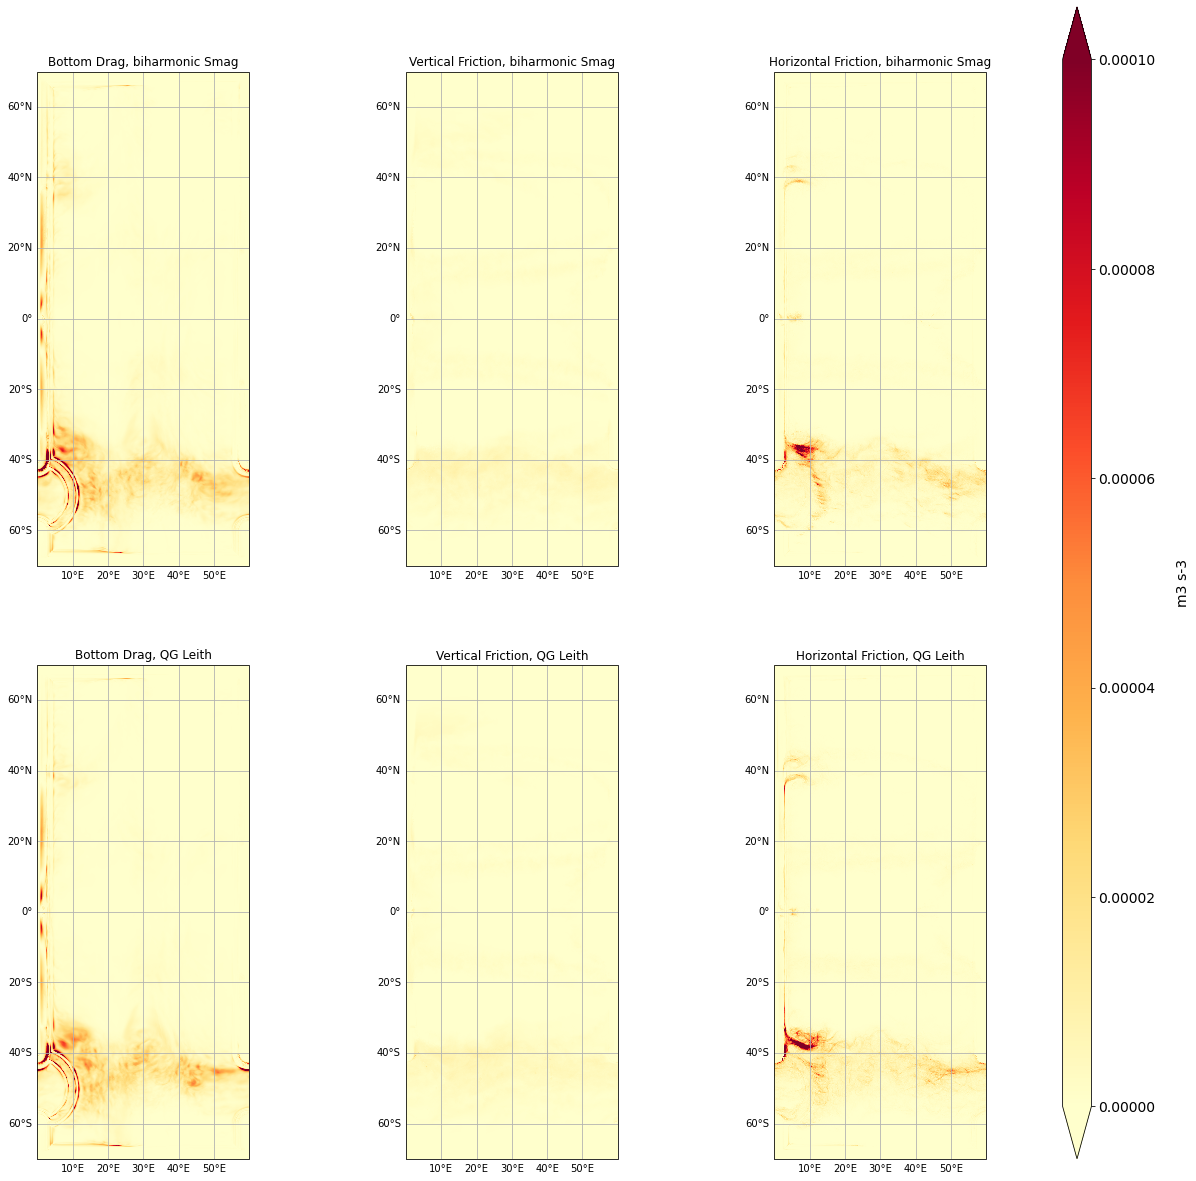

In [56]:
vmin = 0
vmax = 0.0001
fldlist = ['KE_bottom_drag', 'KE_vertical_viscosity', 'KE_horvisc']
labellist = ['Bottom Drag', 'Vertical Friction', 'Horizontal Friction']
  
figname = 'figures/budget/KE_sinks.png'

fig, axs = plt.subplots(2,3,figsize=(20,20),subplot_kw={'projection':ccrs.PlateCarree()})
for fld, lb, ind in zip(fldlist, labellist, range(len(fldlist))):
    # biharmonic Smag
    dst = dst_list[0]
    exp = exp_list[0]
    ax = axs[0, ind]
    p = (-1*dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            vmax=vmax, vmin=vmin, cmap=cmap,
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
    ) 
    ax.set(title = '%s, %s' %(lb, exp))    
    
    # QG Leith
    dst = dst_list[1]
    exp = exp_list[1]
    ax = axs[1, ind]
    p = (-1*dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            vmax=vmax, vmin=vmin, cmap=cmap,
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
    ) 
    ax.set(title = '%s, %s' %(lb, exp))    
    
for ax in axs.flatten():
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
        
# colorbar
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.87, 0.125, 0.02, 0.8])
cb = fig.colorbar(p, cax=cax,extend='both')
cb.ax.tick_params(labelsize=14)
cb.set_label(label='m3 s-3',size=14, labelpad=20)#, y=0.45)
#fig.suptitle('%s, %i day average' %(exp_lb, nr_days_per_interval), y=0.95)
#plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)

### Logarithmic scale

In [62]:
newcmap = cm.get_cmap('Spectral_r')
#newcmap_n = newcmap_p(np.linspace(0, 1, ))
#newcmap_n = ListedColormap(newcmap_n)
#newcmap.set_bad(color='gray')    

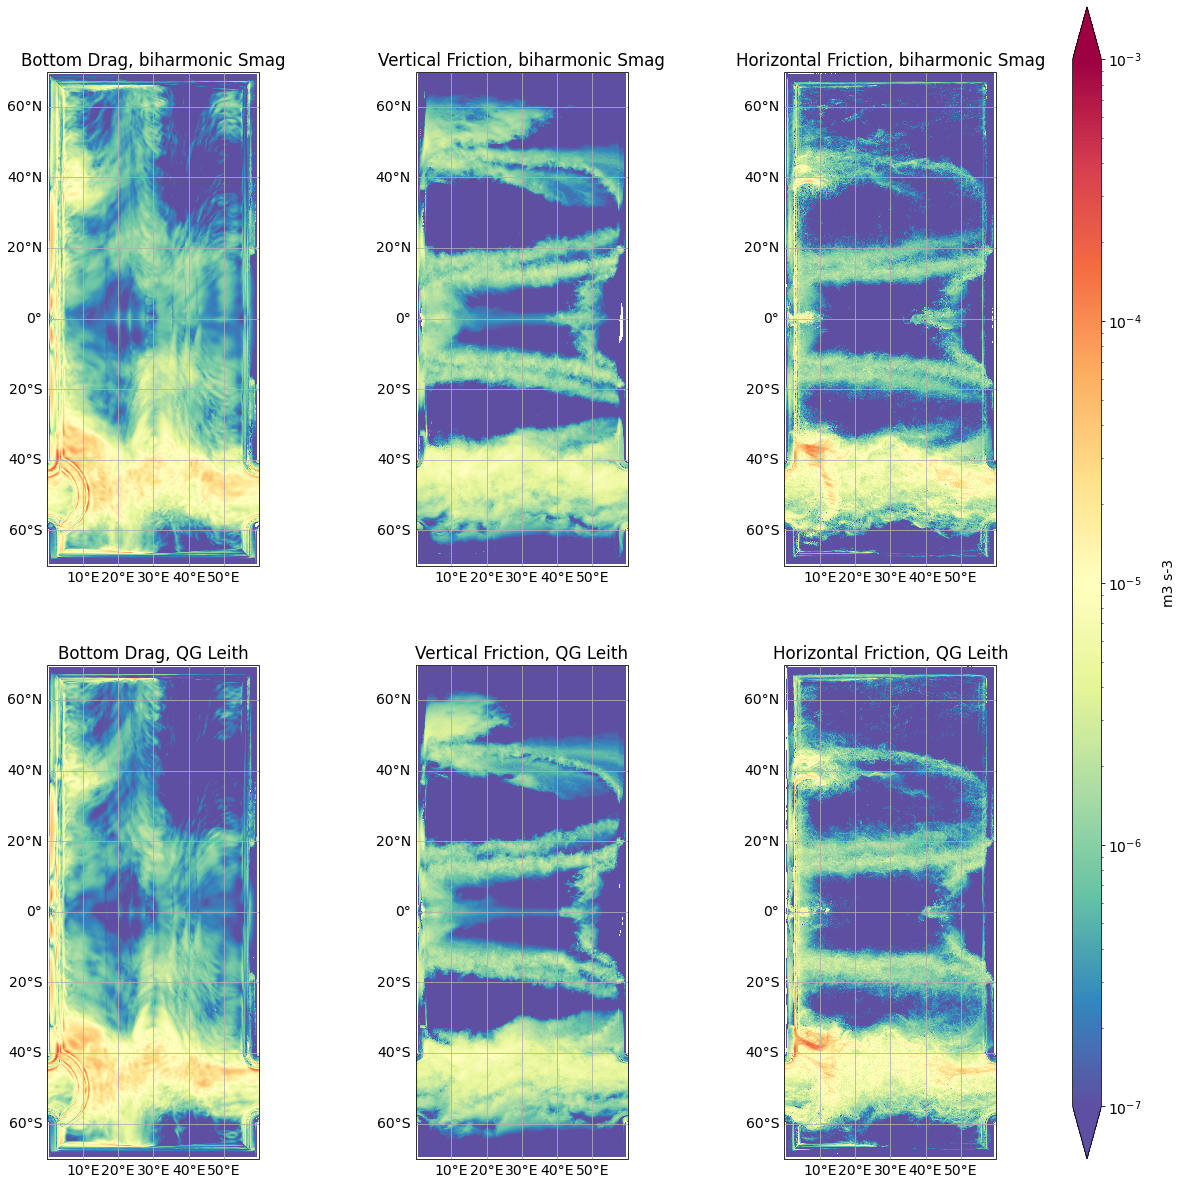

In [133]:
vmin = 1e-7
vmax = 1e-3

fldlist = ['KE_bottom_drag', 'KE_vertical_viscosity', 'KE_horvisc']
labellist = ['Bottom Drag', 'Vertical Friction', 'Horizontal Friction']
  
figname = 'figures/budget/KE_sinks.png'

fig, axs = plt.subplots(2,3,figsize=(20,20),subplot_kw={'projection':ccrs.PlateCarree()})
for fld, lb, ind in zip(fldlist, labellist, range(len(fldlist))):
    # biharmonic Smag
    dst = dst_list[0]
    exp = exp_list[0]
    ax = axs[0, ind]
    p = (-1*dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            cmap=newcmap,
            norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
    ) 
    ax.set(title = '%s, %s' %(lb, exp))    
    
    # QG Leith
    dst = dst_list[1]
    exp = exp_list[1]
    ax = axs[1, ind]
    p = (-1*dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            cmap=newcmap,
            norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
    ) 
    ax.set(title = '%s, %s' %(lb, exp))    
    
for ax in axs.flatten():
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
        
# colorbar
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.87, 0.125, 0.02, 0.8])
cb = fig.colorbar(p, cax=cax,extend='both')
cb.ax.tick_params(labelsize=14)
cb.set_label(label='m3 s-3',size=14, labelpad=20)#, y=0.45)

fig.suptitle = 'Energy extraction rates, %s day average' %(nr_days)
figname = 'figures/KE_sinks_log.png'
plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)

## Bar plot

In [161]:
fldlist = ['KE_bottom_drag', 'KE_vertical_viscosity', 'KE_horvisc']
labellist = ['Bottom Drag', 'Vertical Friction', 'Horizontal Friction']

dst_integrals_list = []
for dst in dst_list:
    dst_integrals = xr.Dataset()
    for fld in fldlist:
        dst_integrals[fld] = ((-1 * dst[fld]).sum(dim='zl') * st.area_t).sum(dim=['xh','yh'])
        
    dst_integrals_list.append(dst_integrals)

In [162]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 14}
pylab.rcParams.update(params)

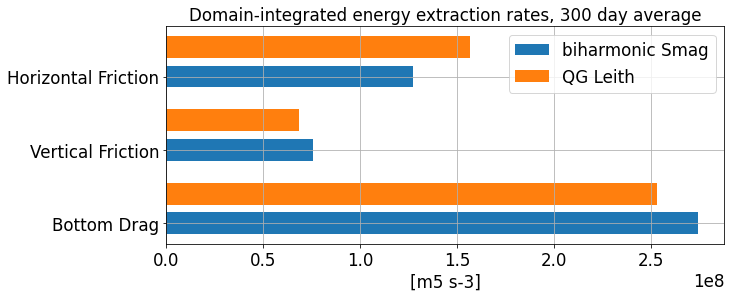

In [163]:
colorlist = ['tab:blue', 'tab:orange']

fig, ax = plt.subplots(1,1, figsize=(10,4))

X = np.arange(len(fldlist))

# Smag
dst_integrals = dst_integrals_list[0]
exp = exp_list[0]
color = colorlist[0]
    
datalist = []
for fld in fldlist:
    datalist.append(dst_integrals[fld])
ax.barh(X, datalist, color=color, height = 0.3, label=exp)

# QG Leith
dst_integrals = dst_integrals_list[1]
exp = exp_list[1]
color = colorlist[1]
    
datalist = []
for fld in fldlist:
    datalist.append(dst_integrals[fld])
ax.barh(X+0.4, datalist, color=color, height = 0.3, label=exp)

ax.legend()
ax.set_yticks(X)
ax.set_yticklabels(labellist)
ax.set_xlabel('[m5 s-3]')
ax.set_title('Domain-integrated energy extraction rates, %s day average' %(nr_days))
ax.grid('on')  

fig.subplots_adjust(wspace=0.5)

figname = 'figures/KE_sinks_bar.png'
plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)

# KE sources

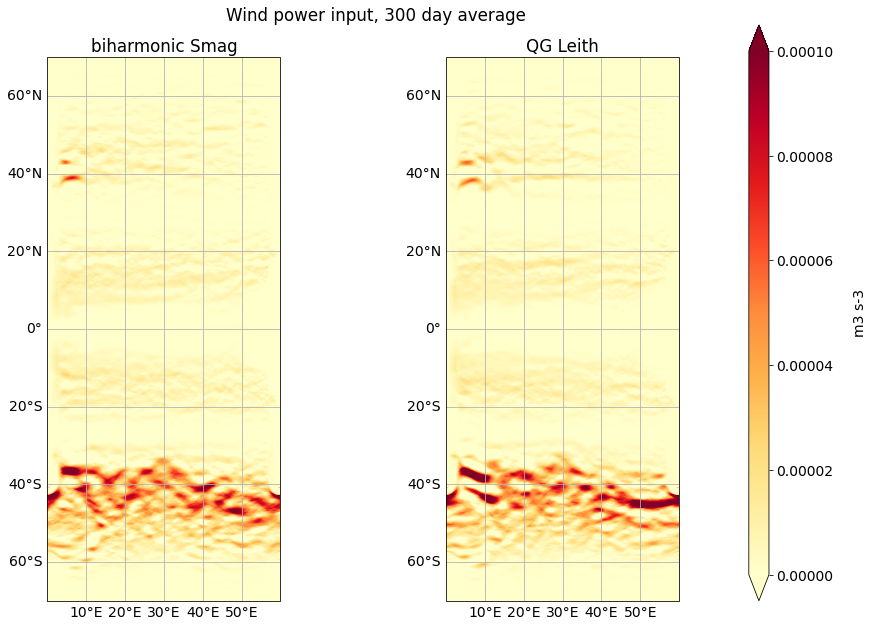

In [101]:
vmin = 0
vmax = 0.0001
fld = 'KE_stress'
lb = 'Wind power input'
  

fig, axs = plt.subplots(1,2,figsize=(14,10),subplot_kw={'projection':ccrs.PlateCarree()})

# biharmonic Smag
dst = dst_list[0]
exp = exp_list[0]
ax = axs[0]
p = (dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            vmax=vmax, vmin=vmin, cmap=cmap,
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
) 
ax.set(title = '%s' %exp)   
    
# QG Leith
dst = dst_list[1]
exp = exp_list[1]
ax = axs[1]
p = (dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            vmax=vmax, vmin=vmin, cmap=cmap,
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
) 
ax.set(title = '%s' %exp)
    
for ax in axs.flatten():
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
        
# colorbar
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.87, 0.125, 0.02, 0.8])
cb = fig.colorbar(p, cax=cax,extend='both')
cb.ax.tick_params(labelsize=14)
cb.set_label(label='m3 s-3',size=14, labelpad=20)#, y=0.45)
fig.suptitle('Wind power input, %i day average' %(nr_days), y=0.95)
figname = 'figures/KE_sources.png'
plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)

### Bar plot

In [167]:
fldlist = ['KE_stress']

for dst, dst_integrals in zip(dst_list, dst_integrals_list):
    dst_integrals[fld] = ((dst[fld]).sum(dim='zl') * st.area_t).sum(dim=['xh','yh'])
        

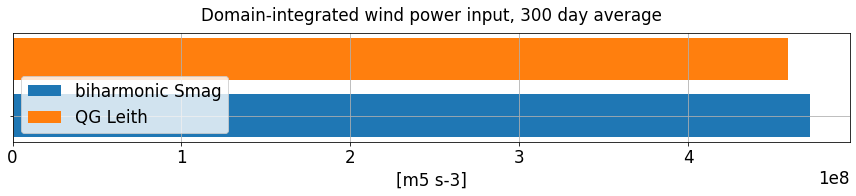

In [172]:
colorlist = ['tab:blue', 'tab:orange']

fig, ax = plt.subplots(1,1, figsize=(15,2))

X = np.arange(len(fldlist))

# Smag
dst_integrals = dst_integrals_list[0]
exp = exp_list[0]
color = colorlist[0]
    
datalist = []
for fld in fldlist:
    datalist.append(dst_integrals[fld])
ax.barh(X, datalist, color=color, height = 0.3, label=exp)

# QG Leith
dst_integrals = dst_integrals_list[1]
exp = exp_list[1]
color = colorlist[1]
    
datalist = []
for fld in fldlist:
    datalist.append(dst_integrals[fld])
ax.barh(X+0.4, datalist, color=color, height = 0.3, label=exp)

ax.legend(loc='lower left')
ax.set_yticks(X)
ax.set_yticklabels([''])
ax.set_xlabel('[m5 s-3]')
ax.set_title('Domain-integrated wind power input, %i day average' %nr_days, y=1.06)
ax.grid('on')  

fig.subplots_adjust(wspace=0.5)

figname = 'figures/KE_sources_bar.png'
plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)

# Depth-integrated kinetic energy

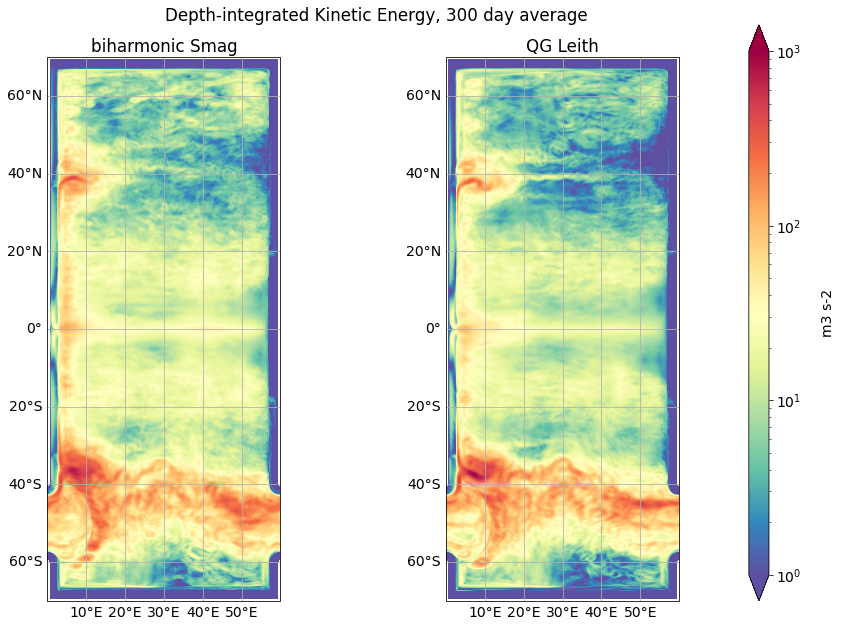

In [134]:
vmin = 1
vmax = 1000
fld = 'hKE'
lb = 'Kinetic energy'
  

fig, axs = plt.subplots(1,2,figsize=(14,10),subplot_kw={'projection':ccrs.PlateCarree()})

# biharmonic Smag
dst = dst_list[0]
exp = exp_list[0]
ax = axs[0]
p = (dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
            cmap=newcmap,
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
) 
ax.set(title = '%s' %exp)   
    
# QG Leith
dst = dst_list[1]
exp = exp_list[1]
ax = axs[1]
p = (dst[fld]).sum(dim='zl').plot(
            ax=ax, 
            norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
            cmap=newcmap,
            #cbar_kwargs = {'label': 'm3 s-3'},
            add_colorbar=False,
            transform=ccrs.PlateCarree()
) 
ax.set(title = '%s' %exp)
    
for ax in axs.flatten():
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
        
# colorbar
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.87, 0.125, 0.02, 0.8])
cb = fig.colorbar(p, cax=cax,extend='both')
cb.ax.tick_params(labelsize=14)
cb.set_label(label='m3 s-2',size=14, labelpad=20)#, y=0.45)
fig.suptitle('Depth-integrated Kinetic Energy, %i day average' %(nr_days), y=0.95)
figname = 'figures/KE.png'
plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)

In [148]:
fld = 'hKE'
for dst, dst_integrals in zip(dst_list, dst_integrals_list):
        dst_integrals[fld] = ((dst[fld]).sum(dim='zl') * st.area_t).sum(dim=['xh','yh'])
        

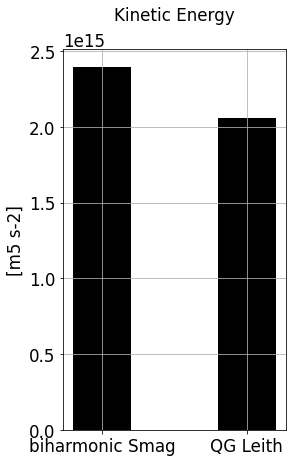

In [150]:
fig, ax = plt.subplots(1,1, figsize=(4,7))

X = np.arange(2)


datalist = [
    dst_integrals_list[0][fld],
    dst_integrals_list[1][fld]
]

ax.bar(X, datalist, color='k', width = 0.4, label=exp)

ax.set_xticks(X)
ax.set_xticklabels(exp_list)
ax.set_ylabel('[m5 s-2]')
ax.set_title('Kinetic Energy', y=1.06)
ax.grid('on')  

fig.subplots_adjust(wspace=0.5)

figname = 'figures/KE_bar.png'
plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)